<table style="border: none" align="center">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="4" color="black"><b>  Demonstrate adversarial training using ART  </b></font></font></th>
   </tr> 
</table>

In this notebook we demonstrate adversarial training using ART on the IRIS dataset.

Sensitivity to training set details

https://nbviewer.jupyter.org/github/ageron/handson-ml2/blob/master/06_decision_trees.ipynb


https://github.com/rasbt/stat451-machine-learning-fs20


## Contents

1.	[Load prereqs and data](#prereqs)
2.  [Train and evaluate a baseline classifier](#classifier)
3.  [Adversarially train a robust classifier](#adv_training)
4.	[Evaluate the robust classifier](#evaluation)

<a id="prereqs"></a>
## 1. Load prereqs and data

In [ ]:
#!pip install mlxtend
#!pip install watermark

In [1]:
%reload_ext watermark
%watermark  -d -u -a 'Habtamu' -v -p numpy,pandas,scipy,matplotlib,sklearn,mlxtend,six,tarfile

Habtamu 
last updated: 2020-11-14 

CPython 3.8.3
IPython 7.18.1

numpy 1.19.2
pandas 1.1.3
scipy 1.4.1
matplotlib 3.3.2
sklearn 0.22.2
mlxtend 0.17.3
six 1.15.0
tarfile 0.9.0


In [2]:
import os
import sys
import six
from typing import Callable, List, Optional, Tuple, Union, TYPE_CHECKING
import shutil
import zipfile
import tarfile

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

#### Load Dataset into a Numpy Array

In [3]:
_folder = os.path.expanduser("C:\\Users\\Hade\\Google Drive\\_Code\\Github\\adversarial-robustness-toolbox\\")
DATASET_TYPE = Tuple[Tuple[np.ndarray, np.ndarray], Tuple[np.ndarray, np.ndarray], float, float]
DATA_PATH = os.path.join(_folder, "data")
ART_NUMPY_DTYPE = np.float32

In [4]:
def _extract(full_path: str, path: str) -> bool:
    archive: Union[zipfile.ZipFile, tarfile.TarFile]
    if full_path.endswith("tar"):
        if tarfile.is_tarfile(full_path):
            archive = tarfile.open(full_path, "r:")
    elif full_path.endswith("tar.gz"):
        if tarfile.is_tarfile(full_path):
            archive = tarfile.open(full_path, "r:gz")
    elif full_path.endswith("zip"):
        if zipfile.is_zipfile(full_path):
            archive = zipfile.ZipFile(full_path)
        else:
            return False
    else:
        return False

    try:
        archive.extractall(path)
    except (tarfile.TarError, RuntimeError, KeyboardInterrupt):
        if os.path.exists(path):
            if os.path.isfile(path):
                os.remove(path)
            else:
                shutil.rmtree(path)
        raise
    return True

In [5]:
def get_file(filename: str, url: str, path: Optional[str] = None, extract: bool = False) -> str:
    """
    Downloads a file from a URL if it not already in the cache. The file at indicated by `url` is downloaded to the
    path `path` (default is ~/data). and given the name `filename`. Files in tar, tar.gz, tar.bz, and zip formats
    can also be extracted. This is a simplified version of the function with the same name in Keras.

    :param filename: Name of the file.
    :param url: Download URL.
    :param path: Folder to store the download. If not specified, `~/data` is used instead.
    :param extract: If true, tries to extract the archive.
    :return: Path to the downloaded file.
    """
    if path is None:
        path_ = os.path.expanduser(DATA_PATH)
    else:
        path_ = os.path.expanduser(path)
    
    if not os.path.exists(path_):
        os.makedirs(path_)

    if extract:
        extract_path = os.path.join(path_, filename)
        full_path = extract_path + ".tar.gz"
    else:
        full_path = os.path.join(path_, filename)

    # Determine if dataset needs downloading
    download = not os.path.exists(full_path)

    if download:
        print("Downloading data from %s", url)
        error_msg = "URL fetch failure on {}: {} -- {}"
        try:
            try:
                from six.moves.urllib.error import HTTPError, URLError
                from six.moves.urllib.request import urlretrieve
                # The following two lines should prevent occasionally occurring
                # [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:847)
                import ssl

                ssl._create_default_https_context = ssl._create_unverified_context

                urlretrieve(url, full_path)
            except HTTPError as exception:
                raise Exception(error_msg.format(url, exception.code, exception.msg)) from HTTPError  # type: ignore
            except URLError as exception:
                raise Exception(error_msg.format(url, exception.errno, exception.reason)) from HTTPError
        except (Exception, KeyboardInterrupt):
            if os.path.exists(full_path):
                os.remove(full_path)
            raise

    if extract:
        if not os.path.exists(extract_path):
            _extract(full_path, path_)
        return extract_path

    return full_path

In [6]:
def to_categorical(labels: np.ndarray, nb_classes: Optional[int] = None) -> np.ndarray:
    """
    Convert an array of labels to binary class matrix.

    :param labels: An array of integer labels of shape `(nb_samples,)`.
    :param nb_classes: The number of classes (possible labels).
    :return: A binary matrix representation of `y` in the shape `(nb_samples, nb_classes)`.
    """
    labels = np.array(labels, dtype=np.int32)
    if nb_classes is None:
        nb_classes = np.max(labels) + 1
    categorical = np.zeros((labels.shape[0], nb_classes), dtype=np.float32)
    categorical[np.arange(labels.shape[0]), np.squeeze(labels)] = 1
    return categorical

In [7]:
def preprocess(x: np.ndarray, y: np.ndarray, nb_classes: int = 10,) -> Tuple[np.ndarray, np.ndarray]:
    """
    Scales `x` to [0, 1] and converts `y` to class categorical confidences.

    :param x: Data instances.
    :param y: Labels.
    :param nb_classes: Number of classes in dataset.
    :return: Rescaled values of `x`, `y`.
    """
    
    min_, max_ = np.amin(x), np.amax(x)
    normalized_x = (x - min_) / (max_ - min_)
    #categorical_y = to_categorical(y, nb_classes)
    categorical_y = y
    
    return normalized_x, categorical_y

#### Shuffle Dataset and Create Training and Test Subsets

In [8]:
def load_iris(raw: bool = False, test_set: float = 0.3) -> DATASET_TYPE:
    """
    Loads the UCI Iris dataset from `DATA_PATH` or downloads it if necessary.

    :param raw: `True` if no preprocessing should be applied to the data. Otherwise, data is normalized to 1.
    :param test_set: Proportion of the data to use as validation split. The value should be between 0 and 1.
    :return: Entire dataset and labels.
    """
    # Download data if needed
    path = get_file(
        "iris.data",
        path=DATA_PATH,
        extract=False,
        url="https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data",
    )

    data = np.loadtxt(path, delimiter=",", usecols=(0, 1, 2, 3), dtype=ART_NUMPY_DTYPE)
    #data = np.loadtxt(path, delimiter=",", usecols=(2, 3), dtype=ART_NUMPY_DTYPE)
    labels = np.loadtxt(path, delimiter=",", usecols=4, dtype=str)

    # Preprocess
    if not raw:
        #Get Class Labels into a NumPy Array
        label_map = {"Iris-setosa": 0, "Iris-versicolor": 1, "Iris-virginica": 2}
        labels = np.array([label_map[labels[i]] for i in range(labels.size)], dtype=np.int32)
        data, labels = preprocess(data, labels, nb_classes=3)
    min_, max_ = np.amin(data), np.amax(data)

    # Split training and test sets
    indices = np.arange(labels.shape[0])
    # to make this notebook's output stable across runs
    rnd = np.random.RandomState(42)
    shuffled_indices = rnd.permutation(indices)
    
    X_shuffled, y_shuffled = data[shuffled_indices], labels[shuffled_indices]
    X_train, y_train = X_shuffled[:105], y_shuffled[:105]
    X_test, y_test = X_shuffled[105:], y_shuffled[105:]
    
    return (X_train, y_train), (X_test, y_test), min_, max_ , data , labels


In [9]:
(X_train, y_train), (X_test, y_test), min_, max_, X, y = load_iris()

In [10]:
y_train

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0,
       0, 1, 2, 2, 1, 2, 1, 2, 1, 0, 2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0,
       1, 2, 0, 1, 2, 0, 2, 2, 1, 1, 2, 1, 0, 1, 2, 0, 0, 1, 1, 0, 2, 0,
       0, 1, 1, 2, 1, 2, 2, 1, 0, 0, 2, 2, 0, 0, 0, 1, 2])

In [11]:
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (105, 4)
y_train.shape: (105,)
X_test.shape: (45, 4)
y_test.shape: (45,)


#### represented in dataframe

In [12]:
#Loading the dataset
from sklearn.datasets import load_iris

x = load_iris()
df = pd.DataFrame(x.data, columns = x.feature_names)
df["Label"] = x.target
# X = df.drop("Label",1)   #Feature Matrix
# y = df["Label"]          #Target Variable
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## 3 Plot Dataset

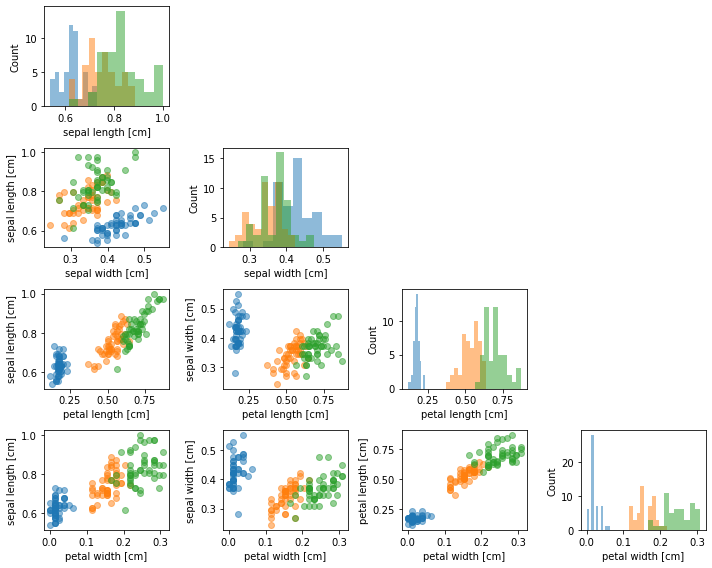

In [13]:
from mlxtend.plotting import scatterplotmatrix


names = ['sepal length [cm]', 'sepal width [cm]',
         'petal length [cm]', 'petal width [cm]']

fig, axes = scatterplotmatrix(X[y==0], figsize=(10, 8), alpha=0.5)
fig, axes = scatterplotmatrix(X[y==1], fig_axes=(fig, axes), alpha=0.5)
fig, axes = scatterplotmatrix(X[y==2], fig_axes=(fig, axes), alpha=0.5, names=names)

plt.tight_layout()
plt.show()

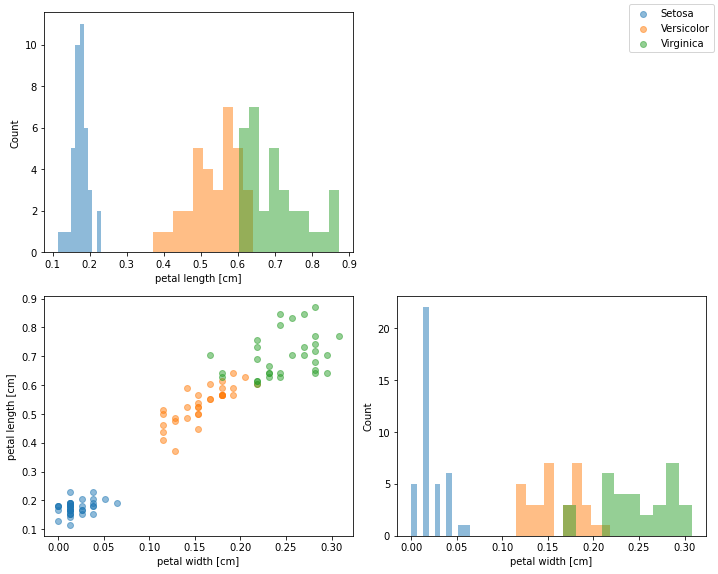

In [14]:
names = ['petal length [cm]', 'petal width [cm]']  #  2=petal length, 3=petal width

fig, axes = scatterplotmatrix(X_train[y_train==0][:,2:], figsize=(10, 8), alpha=0.5, label="Setosa")
fig, axes = scatterplotmatrix(X_train[y_train==1][:,2:], fig_axes=(fig, axes), alpha=0.5, label="Versicolor")
fig, axes = scatterplotmatrix(X_train[y_train==2][:,2:], fig_axes=(fig, axes), alpha=0.5, names=names, label="Virginica")

fig.legend()

plt.tight_layout()
plt.show()

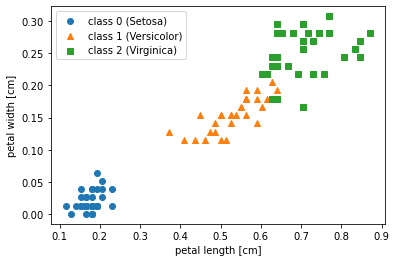

In [15]:
#  2=petal length, 3=petal width
plt.scatter(X_train[y_train == 0, 2],   
            X_train[y_train == 0, 3],
            marker='o',
            label='class 0 (Setosa)')

plt.scatter(X_train[y_train == 1, 2],
            X_train[y_train == 1, 3],
            marker='^',
            label='class 1 (Versicolor)')

plt.scatter(X_train[y_train == 2, 2],
            X_train[y_train == 2, 3],
            marker='s',
            label='class 2 (Virginica)')

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')

plt.show()

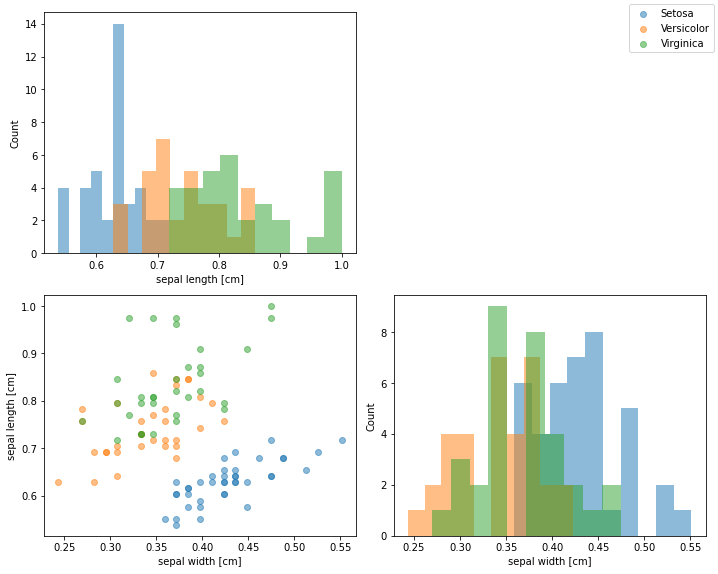

In [16]:
names = ['sepal length [cm]', 'sepal width [cm]']  #  0=sepal length, 1=sepal width

fig, axes = scatterplotmatrix(X_train[y_train==0][:,[0,1]], figsize=(10, 8), alpha=0.5, label="Setosa")
fig, axes = scatterplotmatrix(X_train[y_train==1][:,[0,1]], fig_axes=(fig, axes), alpha=0.5, label="Versicolor")
fig, axes = scatterplotmatrix(X_train[y_train==2][:,[0,1]], fig_axes=(fig, axes), alpha=0.5, names=names, label="Virginica")

fig.legend()

plt.tight_layout()
plt.show()

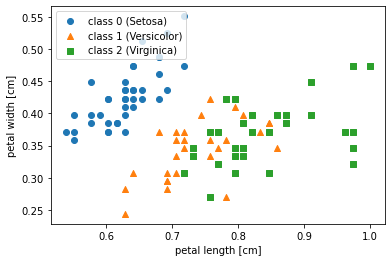

In [17]:
#  0=sepal length, 1=sepal width
#  2=petal length, 3=petal width
plt.scatter(X_train[y_train == 0, 0],   
            X_train[y_train == 0, 1],
            marker='o',
            label='class 0 (Setosa)')

plt.scatter(X_train[y_train == 1, 0],
            X_train[y_train == 1, 1],
            marker='^',
            label='class 1 (Versicolor)')

plt.scatter(X_train[y_train == 2, 0],
            X_train[y_train == 2, 1],
            marker='s',
            label='class 2 (Virginica)')

plt.xlabel('sepal length [cm]')
plt.ylabel('sepal width [cm]')
plt.legend(loc='upper left')

plt.show()

<a id="classifier"></a>
## 2. Train and evaluate a baseline classifier

Fit Decession Tree Model (sklearn)

In [18]:
from sklearn.tree import DecisionTreeClassifier
from mlxtend.plotting import plot_decision_regions


tree_clf = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=2, 
                              random_state=42)


X_train = X_train[:,[0,1]]  #  0=sepal length, 1=sepal width
X_test  = X_test[:, [0,1]]  #  0=sepal length, 1=sepal width

#X_train = X_train[:,2:] #  2=petal length, 3=petal width
#X_test  = X_test[:,2:]  #  2=petal length, 3=petal width

tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

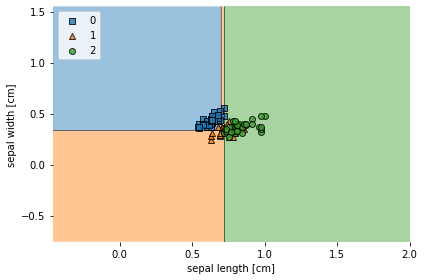

In [19]:
plot_decision_regions(X_train, y_train, tree_clf)

plt.xlabel('sepal length [cm]')
plt.ylabel('sepal width [cm]')

# plt.xlabel('petal length [cm]')
# plt.ylabel('petal width [cm]')

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

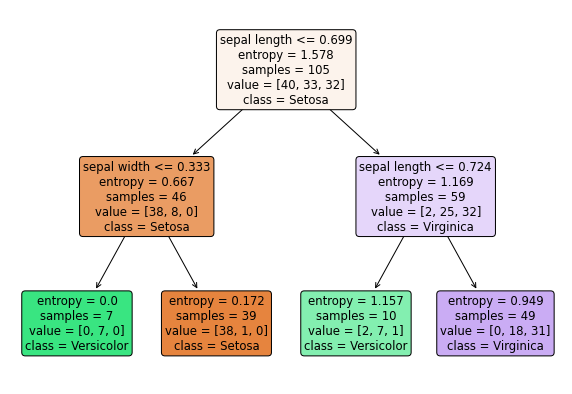

In [20]:
from sklearn.tree import plot_tree


plt.figure(figsize=(10, 7))

plot_tree(tree_clf, 
          filled=True, 
          rounded=True,
          class_names=['Setosa', 
                       'Versicolor',
                       'Virginica'],
          feature_names=['sepal length', #petal
                         'sepal width']) 

plt.show()

### Evaluate the model

Evaluate the classifier performance on original test samples:

In [21]:
from sklearn import metrics
from sklearn import preprocessing  # uses Binarize labels in a one-vs-all fashion

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    
    return metrics.roc_auc_score(y_test, y_pred, average=average)

In [22]:
y_pred=tree_clf.predict(X_test)
print(f"prediction: {y_pred}")

# AUC
print(f"auc: {multiclass_roc_auc_score(y_test, y_pred)}")

# Accuracy
accuracy=metrics.accuracy_score(y_pred,y_test)
print(f"Accuracy: {accuracy}")

# Precision
precision = metrics.precision_score(y_pred,y_test, average='micro')
print(f"Precision: {precision}")

# Recall
recall = metrics.recall_score(y_pred,y_test, average='micro')
print(f"Recall: {recall}")

prediction: [0 2 2 0 2 2 2 2 2 0 2 2 2 1 1 2 1 2 1 0 1 2 2 0 1 2 2 0 2 0 2 2 2 1 2 2 2
 1 2 0 2 1 2 2 2]
auc: 0.7483737939620293
Accuracy: 0.6666666666666666
Precision: 0.6666666666666666
Recall: 0.6666666666666666


In [36]:
#Predicting classes and class probabilities
print(X_test[0:2,:])
tree_clf.predict_proba(X_test[1:2,:])  #0=sepal length, 1=sepal width

array([[0.        , 0.36734694, 0.63265306]])

In [37]:
print(X_test[0:2,:])
tree_clf.predict(X_test[0:2,:]) #0=sepal length, 1=sepal width

[[0.5769231  0.42307693]
 [0.8589744  0.37179488]]


array([0, 2])

## 5 Adversarial-Robustness-Toolbox for scikit-learn DecisionTree

In [42]:
from sklearn.tree import DecisionTreeClassifier
from art.estimators.classification import SklearnClassifier
from art.attacks.evasion import ZooAttack

#### 1 Training scikit-learn DecisionTreesClassifier and attacking with ART Zeroth Order Optimization attack

Create and apply Zeroth Order Optimization Attack with ART

Generate adversarial samples:

In [43]:
def get_adversarial_examples(X_train, X_test, y_train):
    
    # Create and fit DecisionTreeClassifier
    model = DecisionTreeClassifier(max_depth=2, random_state=42)
    model.fit(X=X_train, y=y_train)

    # Create ART classifier for scikit-learn DecisionTreeClassifier
    art_classifier = SklearnClassifier(model=model)

    # Create ART Zeroth Order Optimization attack
    zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=20,
                    binary_search_steps=10, initial_const=1e-3, abort_early=True, use_resize=False, 
                    use_importance=False, nb_parallel=1, batch_size=1, variable_h=0.2)

    # Generate adversarial samples with ART Zeroth Order Optimization attack
    X_train_adv = zoo.generate(X_train)
    X_test_adv  = zoo.generate(X_test)
    
    return X_train_adv, X_test_adv, model

### Experiment : 2

Generate adversarial samples:

In [44]:
X_train_adv, X_test_adv, model = get_adversarial_examples(X_train, X_test, y_train)

ZOO: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:02<00:00, 19.28it/s]


#### Evaluate DecisionTreesClassifier on benign and adversarial samples

evaluate performance on those:

In [45]:
score = model.score(X_train, y_train)
print("Benign Training Score: %.4f" % score)

Benign Training Score: 0.7905


In [46]:
score = model.score(X_train_adv, y_train)
print("Adversarial Training Score: %.4f" % score)

Adversarial Training Score: 0.2381


In [53]:
print(X_train[0:1, :])
prediction = model.predict(X_train[0:1, :])[0]
print("Benign Training Predicted Label: %i" % prediction)

[[0.7692307  0.34615386]]
Benign Training Predicted Label: 2


In [52]:
print(X_train_adv[0:1, :])
prediction = model.predict(X_train_adv[0:1, :])[0]
print("Benign Training Predicted Label: %i" % prediction)

[[0.73720366 0.34615386]]
Benign Training Predicted Label: 1


In [57]:
score = model.score(X_test, y_test)
print("Benign Test Score: %.4f" % score)

Benign Test Score: 0.6889


In [58]:
print(X_test[0:1, :])
prediction = model.predict(X_test[0:1, :])[0]
print("Benign Test Predicted Label: %i" % prediction)

[[0.5769231  0.42307693]]
Benign Test Predicted Label: 0


In [59]:
score = model.score(X_test_adv, y_test)
print("Adversarial Test Score: %.4f" % score)

Adversarial Test Score: 0.2444


In [61]:
print(X_test[0:1, :])
prediction = model.predict(X_test_adv[0:1, :])[0]
print("Adversarial Test Predicted Label: %i" % prediction)

[[0.5769231  0.42307693]]
Adversarial Test Predicted Label: 1
